In [8]:
#import relevant modules
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization

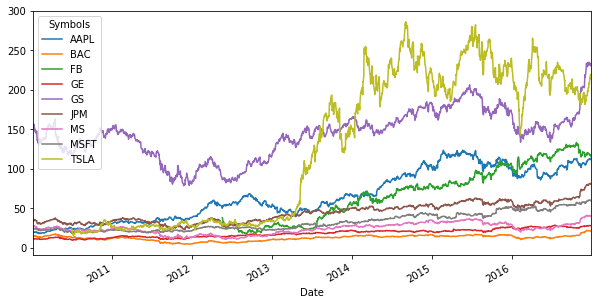

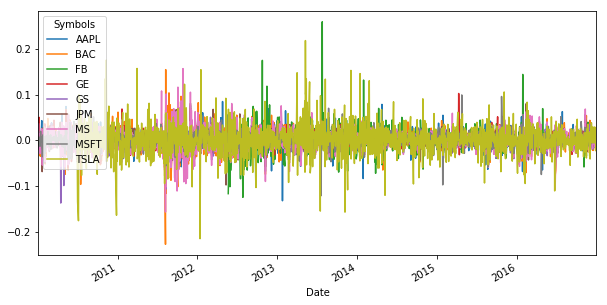

Symbols
AAPL    0.243564
BAC     0.056245
FB      0.238933
GE      0.136637
GS      0.059630
JPM     0.123718
MS      0.057631
MSFT    0.126285
TSLA    0.336881
dtype: float64
Symbols      AAPL       BAC        FB        GE        GS       JPM        MS  \
Symbols                                                                         
AAPL     0.070043  0.032483  0.020777  0.021878  0.024561  0.025194  0.030538   
BAC      0.032483  0.128815  0.024548  0.046745  0.072444  0.079708  0.102285   
FB       0.020777  0.024548  0.155319  0.016040  0.021190  0.019992  0.028000   
GE       0.021878  0.046745  0.016040  0.047390  0.035303  0.039082  0.048540   
GS       0.024561  0.072444  0.021190  0.035303  0.074655  0.059627  0.081797   
JPM      0.025194  0.079708  0.019992  0.039082  0.059627  0.074002  0.079924   
MS       0.030538  0.102285  0.028000  0.048540  0.081797  0.079924  0.130907   
MSFT     0.024219  0.035320  0.020814  0.023991  0.028368  0.030018  0.036199   
TSLA     0.030

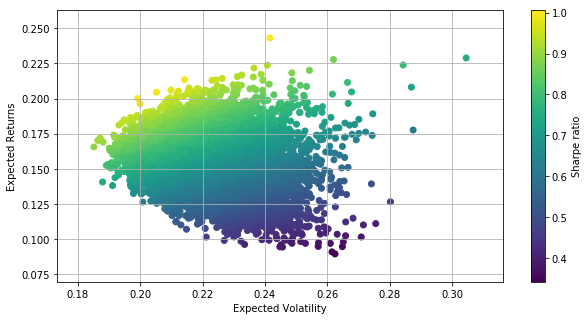

Optimal weights: [0.498 0.    0.174 0.184 0.    0.    0.    0.009 0.136]
Expected return, volatility and sharpe ratio: [0.23496308 0.21274793 1.10442004]


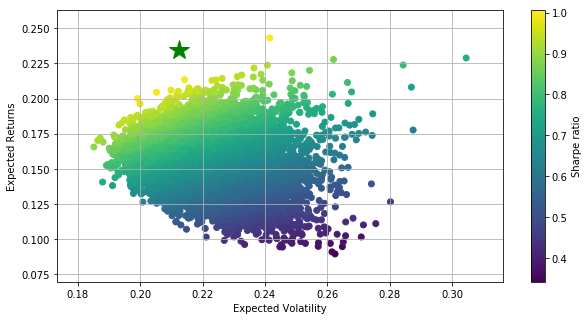

In [35]:
#initialize stock data parameters
stocks = ['AAPL', 'BAC', 'FB', 'GE', 'GS', 'JPM', 'MS', 'MSFT', 'TSLA' ]

start_date = '01/01/2010'
end_date = '01/01/2017'

#fetch stock data from yahoo API
def fetch_data( stocks ):
    data = web.DataReader( stocks , data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
    return data


def show_data(data):
    data.plot(figsize = ( 10, 5 ))
    plt.show()

#calculate and display daily returns
def calculate_returns(data):
    returns = np.log(data/data.shift(1))
    return returns

def plot_daily_returns(returns):
    returns.plot( figsize = ( 10, 5 ) )
    plt.show()
    
#print out mean and covariance for the 252 trading days in the year
def returns_stats(returns):
    print( returns.mean() * 252)
    print( returns.cov() * 252)
    

#define weights for the stocks in this portfolio. for this test code
#I would be using random weights
def calculate_weights(stocks):
    weights = np.random.random( len(stocks) )
    weights /= np.sum(weights)
    return weights;

#define expected portfolio return and variance
def calculate_portfolio_returns( returns, weights ):
    portfolio_returns = np.sum( returns.mean() * weights ) * 252
    print( "Expected portfolio return", portfolio_returns )
    

def calculate_portfolio_variance( returns, weights ):
    portfolio_variance = np.sqrt( np.dot(weights.T, np.dot(returns.cov() * 252, weights )))
    print( "Expected variance:", portfolio_variance )
    
    
#setup monte carlo simulation
def generate_portfolio( weights, returns ):
    preturns = []
    pvariances = []
    
    for i in range (10000):
        weights = np.random.random( len(stocks) )
        weights /= np.sum(weights)
        preturns.append(np.sum( returns.mean() * weights ) * 252)
        pvariances.append(np.sqrt( np.dot(weights.T, np.dot(returns.cov() * 252, weights ))))
        
    preturns = np.array(preturns)
    pvariances = np.array(pvariances)
    return preturns, pvariances

def plot_portfolios(returns, variances ):
    plt.figure( figsize = ( 10,5 ) )
    plt.scatter(variances, returns, c = returns/variances, marker = 'o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label = 'Sharpe ratio')
    plt.show()
    
    
#define optimiztion function using sharpe ratio
def stats( weights, returns ):
    portfolio_return = np.sum( returns.mean() * weights ) * 252
    portfolio_volatility = np.sqrt( np.dot(weights.T, np.dot(returns.cov() * 252, weights )))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])


def min_sharpe( weights, returns ):
    return -stats( weights, returns )[2]

def optimize_portfolio( weights, returns ):
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
    bounds = tuple((0,1) for x in range (len(stocks)))
    optimum = optimization.minimize(fun=min_sharpe, x0=weights, args=returns, method='SLSQP', bounds=bounds, constraints=constraints )
    return optimum

def print_optimal_portfolio(optimum, returns):
    print("Optimal weights:", optimum['x'].round(3))
    print("Expected return, volatility and sharpe ratio:", stats(optimum['x'].round(3), returns))
              
def show_optimal_portfolio(optimum, returns, preturns, pvariances ):
    plt.figure(figsize=( 10,5 ))
    plt.scatter(pvariances, preturns, c = preturns/pvariances, marker = 'o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.colorbar(label = 'Sharpe ratio')
    plt.plot(stats(optimum['x'], returns)[1], stats(optimum['x'], returns)[0], 'g*', markersize = 20)
    plt.show()
              


if __name__ == "__main__":
    data = fetch_data(stocks)
    show_data(data)
    returns = calculate_returns(data)
    plot_daily_returns(returns)
    returns_stats(returns)
    weights = calculate_weights(stocks)
    calculate_portfolio_returns(returns, weights)
    calculate_portfolio_variance(returns, weights)
    preturns,pvariances = generate_portfolio(weights, returns)
    plot_portfolios(preturns,pvariances)
    optimum = optimize_portfolio(weights,returns)
    print_optimal_portfolio(optimum, returns)
    show_optimal_portfolio(optimum, returns, preturns, pvariances)
    